In [1]:
import asyncio
import time

from math import nan, cos

import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from astropy import wcs
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Column

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.centroids import centroid_sources
from photutils.centroids import centroid_com, centroid_quadratic
from photutils.centroids import centroid_1dg, centroid_2dg

from plotimg import plot_images
from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from lvmagp.focus.curvefit import fit_hyperbola

from IPython.display import display, clear_output

from lvmtipo.wcsarith import Wcsarith


In [2]:
from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()
await lvm.sci.km.start()
await lvm.sci.km.status()

await lvm.sci.agc.start()

In [3]:
ra_h, dec_d = (await lvm.sci.pwi.status()).flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

await lvm.sci.km.slewStart(ra_h, dec_d)


ra_h:dec_d 22.1556069105772:-74.1380427601038


{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 254,
 'Position': 33.28911109428219,
 'DeviceEncoder': {'Position': 3029204.0, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False,
 'CurrentTime': 1675877990399099.0,
 'Simulate': True,
 'SkyPA': 66.57822221885641}

[WARNING]: 'obsfix' made the change 'Set OBSGEO-L to   -70.700560 from OBSGEO-[XYZ]. (FITSFixedWarning)


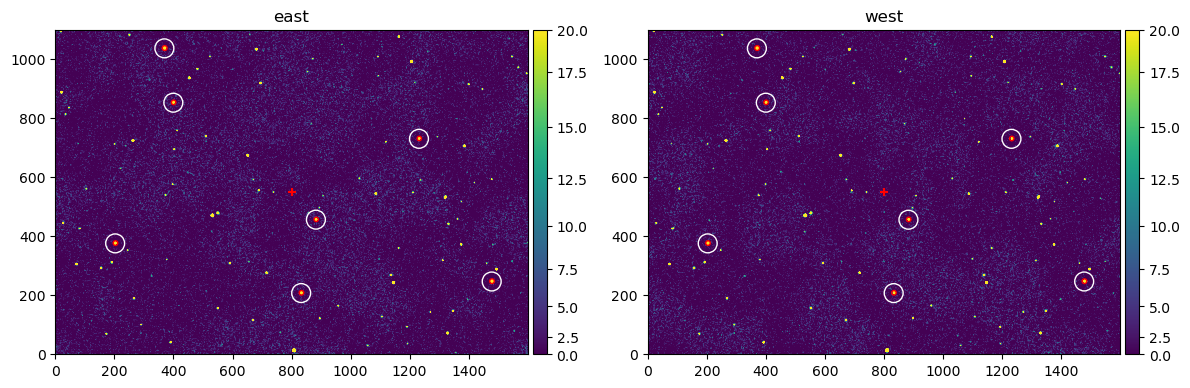

CancelledError: 

In [5]:

#%matplotlib widget
%matplotlib inline

threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01


max_sources = 42
search_boxsize=17

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)


async def expose(time):
    filenames = (await lvm.sci.agc.expose(time)).flatten().unpack("*.filename") 
    images=[]
    for f in filenames:
        img = Image.from_file(f)
        img.wcs = wcs.WCS(img.header)
        images.append(img)
    return [images[0], images[2]]


def filter(image):
        image.data = median_filter(image.data, size=2)
        
        # photutils.background
#        bkg_estimator = MedianBackground()
#        bkg = Background2D(image.data.astype(float), (50, 50), filter_size=(3, 3),
#                           bkg_estimator=bkg_estimator)
#        bkg_median = np.median(bkg.background)
#        bkg_std = np.std(bkg.background)
#        image.data = image.data.astype(float) - bkg.background

        # sep.background
        bkg = sep.Background(image.data.astype(float))
        bkg_median = np.median(bkg)
        bkg_std = np.std(bkg_median)
        image.data = image.data.astype(float) - bkg
        image.header["BKGMED"]=bkg_median
        image.header["BKGSTD"]=bkg_std
#        print(f"median {bkg_median}, std {bkg_std}")

        return image

async def detect(image):
        border = 42
        image.mask = np.ones(image.data.shape, dtype=bool)
        image.mask[border:-border,border:-border] = False

        wcs = image.wcs
        image = source_detection(image)
        image.wcs = wcs

        x, y = image.catalog['x'], image.catalog['y']
        # Create a distance table of point (row) vs point (column)
        sources_dist = np.sqrt((x - x[:,None])**2 + (y - y[:,None])**2)
        # The diagonals are 0, as the distance of a point to itself is 0,
        # but we want that to have a large value so it comes last in sorting
        np.fill_diagonal(sources_dist, np.inf)
        # Get the sorted index for each row
        dist_idx = sources_dist.argsort(axis=1)
        dist_next = [sources_dist[idx, dist_idx[idx]][0] for idx, p in enumerate(image.catalog)]

        if 'dist' in image.catalog.keys():
           image.catalog.replace_column('dist', dist_next)
        else:
           # image.catalog.remove_columns('dist')
           image.catalog.add_column(Column(name='dist', data=dist_next))

        
#        image.catalog.sort("fwhm")
        image.catalog = image.catalog[image.catalog["dist"] > 8]
        image.catalog = image.catalog[image.catalog["peak"] > image.header["BKGMED"]*2]
        image.catalog = image.catalog[image.catalog["ellipticity"] < 0.35]
#        image.catalog = image.catalog[image.catalog["fwhm"] > 8]
#        image.catalog = image.catalog[image.catalog["peak"] > 50]
        image.catalog = image.catalog[image.catalog["peak"] < 60000]
        image.catalog = image.catalog[image.catalog["dist"] > 40]
           

#        image.catalog = image.catalog[image.catalog["peak"] < 60000]

#        print(len[sources[idx] for idx, p in enumerate(P) if dist_idx[idx][0] < 2]))
#        print(len[sources[idx] for idx, p in enumerate(P) if dist_idx[idx][0] < 2]))
        image.catalog.sort("peak")
        image.catalog.reverse()
        return image
    


async def centroid(image, sources=None, centroid_func=centroid_com):

        if sources is None:
           sources = np.array([image.catalog['x'], 
                               image.catalog['y']])
        try:
            x, y = centroid_sources(image.data,
                                    sources[0],
                                    sources[1],
                                    box_size=search_boxsize,
                                    centroid_func=centroid_func)
            image.centroid = np.array([x, y])

        except Exception as ex:
            print("Error: no sources")

        return image

async def offset_simple(images, ref_images, guide_on, centroid_func=centroid_com):

    diff_centroid = [None] * len(images)
    for idx, img in enumerate(images):
        images[idx] = filter(images[idx])
        images[idx] = await detect(images[idx])
        await centroid(images[idx], sources=ref_images[idx].centroid, centroid_func=centroid_func)
        print(len(images[idx].centroid.T))

        diff_centroid[idx] = (ref_images[idx].centroid - images[idx].centroid).transpose()
        print(f" centroids {len(ref_images[idx].centroid.T)}:{len(images[idx].centroid.T)}")
#        print(f" centroids {ref_images[idx].centroid.T}:{images[idx].centroid.T}")
        print(f" centroids {diff_centroid[idx]}")

    cen_diff =  np.concatenate([diff_centroid[idx] for idx in range(len(images))])
    cen_min = np.min(cen_diff, axis=0)
    cen_max = np.max(cen_diff, axis=0)
    cen_median = np.median(cen_diff, axis=0)
    cen_std = np.std(cen_diff, axis=0)
    print(f"\nmedian centroid diff {cen_min} {cen_median} {cen_max} {cen_std}")

    offset = np.array([cen_median[1], cen_median[0]])
    offset *= [images[0].header['BINX'], images[0].header['BINY']]
    offset *= [images[0].header['PIXSCALE'], images[0].header['PIXSCALE']]
    offset /= [cos(np.deg2rad(images[0].header['DEC'])), 1.0]
    offset *= [-0.95, 0.95]
    print(f"offset radec diff {offset}")

    if guide_on:
        if (abs(offset) > [0.5, 0.5]).any():
            print(f"correcting {offset}")
            await lvm.sci.pwi.offset(ra_add_arcsec = offset[0], 
                                     dec_add_arcsec = offset[1])

async def offset_radec(images, ref_images, guide_on, centroid_func=centroid_com):

    diff_centroid = [None] * len(images)
    for idx, img in enumerate(images):
        images[idx] = filter(images[idx])
        images[idx] = await detect(images[idx])
        await centroid(images[idx], sources=ref_images[idx].centroid, centroid_func=centroid_func)

        r_img = ref_images[idx]
        img = images[idx]
        print(f"idx ref/img centroid: {len(r_img.centroid)}{len(img.centroid)}")
        r_cen = r_img.wcs.all_pix2world(r_img.centroid[0], r_img.centroid[1], 1, ra_dec_order=True)
        i_cen = img.wcs.all_pix2world(img.centroid[0], img.centroid[1], 1, ra_dec_order=True)
        r_sky = SkyCoord(r_cen[0], r_cen[1], unit="deg")
        i_sky = SkyCoord(i_cen[0], i_cen[1], unit="deg")
        diff_centroid[idx] = np.array(r_sky.spherical_offsets_to(i_sky)).T*3600

    cen_diff = np.concatenate([diff_centroid[idx] for idx in range(len(images))]) 
    cen_min = np.min(cen_diff, axis=0)
    cen_max = np.max(cen_diff, axis=0)
    cen_median = np.median(cen_diff, axis=0)
    cen_std = np.std(cen_diff, axis=0)

    offset = cen_median
    offset *= [-0.95, 0.95]

    print(f"median centroid diff min:{cen_min} med:{cen_median} max:{cen_max} std:{cen_std} asec")
    print(f"offset radec diff {offset}")

    if guide_on:
        if (abs(offset) > [0.5, 0.5]).any():
            print(f"correcting {offset}")
            await lvm.sci.pwi.offset(ra_add_arcsec = offset[0], 
                                     dec_add_arcsec = offset[1])

loop = True

exp_time = 3.0
column = "fwhm"
centroid_func = centroid_com
#centroid_func = centroid_2dg
#centroid_func = centroid_quadratic

ref_images = await expose(exp_time)

for idx, img in enumerate(ref_images):
    ref_images[idx] = filter(ref_images[idx])
    ref_images[idx] = await detect(ref_images[idx])

    await centroid(ref_images[idx], centroid_func=centroid_func)

plot_images(ref_images, cat_max=max_sources, cat_rest=True, figsize=(12, 10))

if not hasattr(ref_images[0], "centroid"):
    loop = False

guide_on = False

while loop:
    await lvm.sci.pwi.status()
    await lvm.sci.km.status()
    await lvm.sci.foc.status()

    images = await expose(exp_time)

    clear_output(wait=True)
    await offset_radec(images, ref_images, guide_on, centroid_func=centroid_func)
    
    plot_images(images, cat_max=max_sources, cat_rest=False, figsize=(12,10))
    await asyncio.sleep(5.0)


In [ ]:
images[0].data.shape

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
mask = ~np.array([1, 0, 1], dtype=bool) 
masked_a = np.ma.masked_array(a, np.repeat(mask, a.shape[1]).reshape(a.shape))
masked_a

In [ ]:
await lvm.sci.pwi.status()
await lvm.sci.km.status()
await lvm.sci.foc.status()

exp_time=2
ref_images = await expose(exp_time)
for idx, img in enumerate(ref_images):
    ref_images[idx] = filter(ref_images[idx])
    ref_images[idx] = await detect(ref_images[idx])

    await centroid(ref_images[idx])
    ref_images[idx].centroid=ref_images[idx].centroid.T[:3].T

r_img=ref_images[0]

await asyncio.sleep(7.0)
#print(r_img.centroid.T[:4])

images = await expose(exp_time)

for idx, img in enumerate(images):
    images[idx] = filter(images[idx])
    images[idx] = await detect(images[idx])

    await centroid(images[idx], sources=ref_images[idx].centroid)

img=images[0]


#print(r_img.centroid)
#print(img.centroid)

r_sky = [SkyCoord(*r_img.wcs.all_pix2world(x, y, 1, ra_dec_order=True), unit="deg") for x, y in r_img.centroid.T]
i_sky = [SkyCoord(*img.wcs.all_pix2world(x, y, 1, ra_dec_order=True), unit="deg") for x, y in img.centroid.T]
i_diff = [r_s.spherical_offsets_to(i_sky[idx]) for idx, r_s in enumerate(r_sky)]
print(np.array([[ra.arcsec, dec.arcsec] for ra, dec in i_diff]))

r_cen = r_img.wcs.all_pix2world(r_img.centroid[0], r_img.centroid[1], 1, ra_dec_order=True)
i_cen = img.wcs.all_pix2world(img.centroid[0], img.centroid[1], 1, ra_dec_order=True)
r_sky = SkyCoord(r_cen[0], r_cen[1], unit="deg")
i_sky = SkyCoord(i_cen[0], i_cen[1], unit="deg")
i_diff=np.array(r_sky.spherical_offsets_to(i_sky)).T*3600
print(i_diff)

np.median(i_diff, axis=0)

In [ ]:
import numpy as np

P = np.array([(33, 9), (34, 13), (62, 119)])

# Finds the n closest points to p in P
def n_closest_points(p, P, n):
    p_vector = np.tile(p, (len(P), 1))
    dists = np.linalg.norm(P-p_vector, axis=1)
    sorted_dists = np.sort(dists)

    # Exclude the 0th element as the distance from p to itself is 0
    return sorted_dists[1:n+1] 

#print(n_closest_points(0, P, 2))
print(n_closest_points(0, P, 1))

In [ ]:
def pClosest(points, K):
    points.sort(key = lambda K: K[0]**2 + K[1]**2)
    print(points)
    return points[:K]

# Driver program
points = [(33, 9), (34, 13), (62, 119), (33, 7), (48, 123)]

K = 1

print(pClosest(points, K))

In [ ]:
P = [(33, 9), (34, 13), (62, 119), (33, 7), (48, 123)]
P = np.array(P)

x, y = P[:,0], P[:,1]
# Create a distance table of point (row) vs point (column)
dist = np.sqrt((x - x[:,None])**2 + (y - y[:,None])**2)
# The diagonals are 0, as the distance of a point to itself is 0,
# but we want that to have a large value so it comes last in sorting
np.fill_diagonal(dist, np.inf)
# Get the sorted index for each row
dist_idx = dist.argsort(axis=1)

idx = 1
print(P[idx])
print(dist_idx)
print(P[dist_idx[idx]][0])
print(dist[idx,dist_idx[idx]][0])



[P[idx] for idx, p in enumerate(P) if dist_idx[idx][0]]
[dist[idx,dist_idx[idx]][0] for idx, p in enumerate(P)]
#[P[idx] for idx, p in enumerate(P) if dist_idx[idx][0] < 2]

In [ ]:
if True:
        image=images[1]

        x, y = image.catalog['x'], image.catalog['y']
        # Create a distance table of point (row) vs point (column)
        sources_dist = np.sqrt((x - x[:,None])**2 + (y - y[:,None])**2)
        # The diagonals are 0, as the distance of a point to itself is 0,
        # but we want that to have a large value so it comes last in sorting
        np.fill_diagonal(sources_dist, np.inf)
        # Get the sorted index for each row
        dist_idx = sources_dist.argsort(axis=1)
        
        print(dist_idx)
        dist_next = [sources_dist[idx, dist_idx[idx]][0] for idx, p in enumerate(image.catalog)]
        print(neigh_dist)        

        if 'dist' in image.catalog.keys():
           image.catalog.replace_column('dist', dist_next)
        else:
           # image.catalog.remove_columns('dist')
           image.catalog.add_column(Column(name='dist', data=dist_next))
#        print(image.catalog['dist'][0])
        print(image.catalog['x', 'y','dist'])